# Required

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import zipfile
import numpy as np
from torchvision import transforms
from torchvision.transforms import functional as F
from PIL import Image
import shutil
from sklearn.model_selection import train_test_split

import torch.optim as optim
from torch.optim import SGD
from tqdm import tqdm
import torchvision.transforms as T

import torchvision
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CocoDetection
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import box_iou

In [3]:
# Set paths for dataset
data_dir = '/content/drive/MyDrive/ColabNotebooks/'
train_zip = os.path.join(data_dir, 'TrainIJCNN2013.zip')
test_zip = os.path.join(data_dir, 'TestIJCNN2013.zip')
annotations_file = '/content/drive/MyDrive/ColabNotebooks/gt.txt'

In [4]:
# -*- coding: utf-8 -*-
"""GTSDB_Faster_RCNN.ipynb"""

# Import necessary libraries
import os
import zipfile
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


# Extract the dataset
train_dir = '/content/train/TrainIJCNN2013'
test_dir = '/content/test/TestIJCNN2013Download'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

with zipfile.ZipFile(train_zip, 'r') as zip_ref:
    zip_ref.extractall('/content')
with zipfile.ZipFile(test_zip, 'r') as zip_ref:
    zip_ref.extractall('/content')

print("Dataset extracted successfully.")
train_dir = '/content/train/TrainIJCNN2013/TrainIJCNN2013'
test_dir = '/content/test/TestIJCNN2013Download/TestIJCNN2013Download'


Dataset extracted successfully.


In [5]:
import shutil

train_dir = 'TrainIJCNN2013'
test_dir = 'TestIJCNN2013Download'
shutil.copy(annotations_file, train_dir)
annotations_file = "/content/TrainIJCNN2013/gt.txt"

In [6]:
# Λίστα για αποθήκευση διαστάσεων
image_dimensions = []

# Διαπέραση όλων των αρχείων στον φάκελο
for filename in os.listdir(train_dir):
    if filename.endswith(".ppm"):  # Έλεγχος για αρχεία .ppm
        file_path = os.path.join(train_dir, filename)
        with Image.open(file_path) as img:
            width, height = img.size  # Απόκτηση πλάτους και ύψους
            image_dimensions.append((filename, width, height))
            print(f"Image: {filename}, Width: {width}, Height: {height}")

# Ανάλυση των αποτελεσμάτων
print(f"\nTotal images: {len(image_dimensions)}")
print(f"Example dimensions: {image_dimensions[:5]}")

Image: 00280.ppm, Width: 1360, Height: 800
Image: 00325.ppm, Width: 1360, Height: 800
Image: 00345.ppm, Width: 1360, Height: 800
Image: 00442.ppm, Width: 1360, Height: 800
Image: 00561.ppm, Width: 1360, Height: 800
Image: 00130.ppm, Width: 1360, Height: 800
Image: 00030.ppm, Width: 1360, Height: 800
Image: 00075.ppm, Width: 1360, Height: 800
Image: 00461.ppm, Width: 1360, Height: 800
Image: 00134.ppm, Width: 1360, Height: 800
Image: 00463.ppm, Width: 1360, Height: 800
Image: 00446.ppm, Width: 1360, Height: 800
Image: 00288.ppm, Width: 1360, Height: 800
Image: 00415.ppm, Width: 1360, Height: 800
Image: 00356.ppm, Width: 1360, Height: 800
Image: 00525.ppm, Width: 1360, Height: 800
Image: 00016.ppm, Width: 1360, Height: 800
Image: 00439.ppm, Width: 1360, Height: 800
Image: 00047.ppm, Width: 1360, Height: 800
Image: 00158.ppm, Width: 1360, Height: 800
Image: 00597.ppm, Width: 1360, Height: 800
Image: 00039.ppm, Width: 1360, Height: 800
Image: 00034.ppm, Width: 1360, Height: 800
Image: 0054

In [7]:
import torch
import os

def parse_annotations(annotations_file, image_dir):
    annotations = []

    # Φόρτωση των annotations
    with open(annotations_file, "r") as f:
        for line_no, line in enumerate(f.readlines()):
            if line_no == 0:  # Παράλειψη της γραμμής επικεφαλίδας
                continue
            fields = line.strip().split(",")
            if len(fields) != 6:  # Αναμενόμενες στήλες: filename, x1, y1, x2, y2, class
                print(f"Skipping malformed line {line_no + 1}: {line.strip()}")
                continue
            filename, x1, y1, x2, y2, class_id = fields
            x1, y1, x2, y2 = float(x1), float(y1), float(x2), float(y2)
            class_id = int(class_id)
            # Έλεγχος για bounding boxes εκτός ορίων εικόνας
            if x1 < 0 or y1 < 0 or x2 > 2048 or y2 > 2048:
                print(f"Skipping bounding box out of bounds: {filename}, [{x1}, {y1}, {x2}, {y2}]")
                continue
            # Έλεγχος για μη έγκυρα bounding boxes
            if x1 >= x2 or y1 >= y2:
                print(f"Skipping invalid bounding box at line {line_no + 1}: [{x1}, {y1}, {x2}, {y2}]")
                continue
            # Έλεγχος για πολύ μικρά bounding boxes
            if abs(x2 - x1) < 10 or abs(y2 - y1) < 10:
                print(f"Skipping small bounding box at line {line_no + 1}: [{x1}, {y1}, {x2}, {y2}]")
                continue
            # Προσθήκη στα annotations
            annotations.append({
                "filename": filename,
                "bbox": [x1, y1, x2, y2],
                "label": class_id
            })

    return annotations
    return annotations


# Example usage
annotations = parse_annotations(annotations_file, train_dir)

# Check the first few annotations to verify the format
print(annotations[:5])
annotations = parse_annotations(annotations_file, train_dir)
print(f"Parsed Annotations: {annotations[:5]}")  # Εμφάνιση των πρώτων 5 γραμμών
print(f"Total annotations: {len(annotations)}")

[{'filename': '/content/TrainIJCNN2013/00000.ppm', 'bbox': [774.0, 411.0, 815.0, 446.0], 'label': 11}, {'filename': '/content/TrainIJCNN2013/00001.ppm', 'bbox': [983.0, 388.0, 1024.0, 432.0], 'label': 40}, {'filename': '/content/TrainIJCNN2013/00001.ppm', 'bbox': [386.0, 494.0, 442.0, 552.0], 'label': 38}, {'filename': '/content/TrainIJCNN2013/00001.ppm', 'bbox': [973.0, 335.0, 1031.0, 390.0], 'label': 13}, {'filename': '/content/TrainIJCNN2013/00002.ppm', 'bbox': [892.0, 476.0, 1006.0, 592.0], 'label': 39}]
Parsed Annotations: [{'filename': '/content/TrainIJCNN2013/00000.ppm', 'bbox': [774.0, 411.0, 815.0, 446.0], 'label': 11}, {'filename': '/content/TrainIJCNN2013/00001.ppm', 'bbox': [983.0, 388.0, 1024.0, 432.0], 'label': 40}, {'filename': '/content/TrainIJCNN2013/00001.ppm', 'bbox': [386.0, 494.0, 442.0, 552.0], 'label': 38}, {'filename': '/content/TrainIJCNN2013/00001.ppm', 'bbox': [973.0, 335.0, 1031.0, 390.0], 'label': 13}, {'filename': '/content/TrainIJCNN2013/00002.ppm', 'bbox

In [8]:
# Define the dataset class for GTSDB
class GTSDBDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, annotations_file, transforms=None):
        self.image_dir = image_dir
        self.transforms = transforms
        self.annotations = parse_annotations(annotations_file, image_dir)

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        annotation = self.annotations[idx]
        img_path = os.path.join(self.image_dir, annotation["filename"])
        img = Image.open(img_path).convert("RGB")

        # Convert bounding boxes and labels to tensors
        bbox = torch.tensor([annotation["bbox"]], dtype=torch.float32)  # (num_boxes, 4)
        label = torch.tensor([annotation["label"]], dtype=torch.int64)  # (num_boxes,)

        target = {"boxes": bbox, "labels": label}

        # Apply transformations if any
        if self.transforms:
            img = self.transforms(img)

        return img, target

In [9]:
# Define transforms for the dataset
transforms = T.Compose([
    T.ToTensor(),  # Convert image to tensor
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Imagenet normalization
])

# Load the dataset
train_dataset = GTSDBDataset(train_dir, annotations_file, transforms=transforms)
test_dataset = GTSDBDataset(test_dir, annotations_file, transforms=transforms)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# ResNet50 Classification

In [10]:
!pip install -q tf2onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 99.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 15.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.62.3 requires protobuf>=4.21.6, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.16.1 requires protobuf<6.0.0dev,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.


In [14]:
!pip install onnx onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 111.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.3 MB/s eta 0:00:00


In [15]:
import onnxruntime

# 1. Ορισμός του ONNX μοντέλου
onnx_model_path = "/content/drive/MyDrive/ColabNotebooks/resnet50.onnx"

# 2. Φόρτωση του ONNX μοντέλου μέσω onnxruntime
session = onnxruntime.InferenceSession(onnx_model_path)

In [18]:
# Ονόματα των εισόδων και εξόδων του ONNX μοντέλου
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

# Faster-RCNN

In [16]:
# Define Faster R-CNN model
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision

def get_faster_rcnn_model(num_classes):
    """
    Load Faster R-CNN with a ResNet50 backbone and modify it for GTSDB.
    """
    # Load pre-trained Faster R-CNN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # Replace the classifier with one for our dataset
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# Initialize the model
num_classes = 43  # 42 traffic sign classes + 1 background
model = get_faster_rcnn_model(num_classes)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 211MB/s]


In [17]:
from sklearn.metrics import precision_score, recall_score
import numpy as np

def evaluate_precision_recall(model, dataloader, device, confidence_threshold=0.1):
    model.eval()  # Set model to evaluation mode
    all_true_labels = []
    all_pred_labels = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for i, output in enumerate(outputs):
                true_boxes = targets[i]["boxes"].cpu().numpy()
                true_labels = targets[i]["labels"].cpu().numpy()

                pred_boxes = output["boxes"].cpu().numpy()
                pred_scores = output["scores"].cpu().numpy()
                pred_labels = output["labels"].cpu().numpy()

                # Filter predictions based on confidence threshold
                mask = pred_scores >= confidence_threshold
                pred_boxes = pred_boxes[mask]
                pred_labels = pred_labels[mask]

                # Append the ground truth and predicted labels
                all_true_labels.extend(true_labels)
                all_pred_labels.extend(pred_labels)

    # Convert to numpy arrays for evaluation
    all_true_labels = np.array(all_true_labels)
    all_pred_labels = np.array(all_pred_labels)

    # Compute precision and recall
    precision = precision_score(all_true_labels, all_pred_labels, average='weighted', zero_division=1)
    recall = recall_score(all_true_labels, all_pred_labels, average='weighted', zero_division=1)

    return precision, recall


In [22]:
import os
import torch
from tqdm import tqdm
checkpoint_path = '/content/drive/MyDrive/ColabNotebooks/checkpoint.pth'
best_model_path = '/content/drive/MyDrive/ColabNotebooks/checkpoints/best_model.pth'

# Training loop with model saving after each epoch and loss calculation
def train_model(model, train_loader, device, optimizer, num_epochs=10, checkpoint_dir='checkpoints'):
    model.train()
    best_loss = float('inf')
    best_epoch = 0

    # Αν υπάρχει ήδη ένα best_model.pth, φόρτωσέ το και ενημέρωσε το best_loss
    if os.path.exists(best_model_path):
        checkpoint = torch.load(best_model_path)
        best_loss = checkpoint.get('best_loss', float('inf'))
        print(f"Loaded existing best model with loss: {best_loss:.4f}")

    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    for epoch in range(num_epochs):
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")  # Γραμμή προόδου
        total_loss = 0

        for images, targets in pbar:
            # Move images and targets to device
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Forward pass and compute loss
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())  # Total loss
            total_loss += loss.item()

            # Backward pass and update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Ενημέρωση της γραμμής προόδου
            pbar.set_postfix(loss=loss.item())

        # Calculate average loss for the epoch
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}")

        # Save the model after every epoch if loss is improving
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_epoch = epoch + 1  # Store best epoch
            model_save_path = os.path.join(checkpoint_dir, f"model_epoch_{best_epoch}_loss_{avg_loss:.4f}.pth")
            torch.save(model.state_dict(), model_save_path)
            print(f"New best model saved at epoch {best_epoch} with avg_loss {best_loss:.4f}")

    # Final model saving after all epochs
    final_model_path = os.path.join(checkpoint_dir, "best_model.pth")
    torch.save(model.state_dict(), final_model_path)
    print(f"Best model saved after epoch {best_epoch} with loss {best_loss:.4f}")

    # Αποθήκευση checkpoint στο Google Drive
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'best_loss': best_loss
    }, checkpoint_path)

    print(f"Checkpoint saved to {checkpoint_path}")

In [23]:
train_model(model, train_loader, device, optimizer, num_epochs=10, checkpoint_dir='checkpoints')

Epoch 1/10:  60%|█████▉    | 64/107 [01:16<00:51,  1.20s/it, loss=0.474]


KeyboardInterrupt: 

In [ ]:
import shutil
import os

checkpoint_path = '/content/checkpoints'
destination_dir = '/content/drive/MyDrive/ColabNotebooks/checkpoints_drive'

if os.path.exists(destination_dir):
    shutil.rmtree(destination_dir)  # Διαγραφή του φακέλου

# Αντιγραφή ολόκληρου του φακέλου από το checkpoint_path στο destination_dir
shutil.copytree(checkpoint_path, destination_dir)

print(f"Folder copied from {checkpoint_path} to {destination_dir}")


Folder copied from /content/checkpoints to /content/drive/MyDrive/ColabNotebooks/checkpoints_drive


In [35]:
def evaluate_precision_recall(model, dataloader, device):
    """
    Evaluation function που τρέχει το Faster R-CNN και χρησιμοποιεί
    το ONNX ResNet50 για ταξινόμηση των ανιχνευμένων πινακίδων.
    """
    model.eval()
    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            detections = model(images)  # Faster R-CNN Inference

            for img_idx, detection in enumerate(detections):
                print(f"🔍 Processing Image {img_idx + 1}")

                # Περνάμε κάθε ανιχνευμένη περιοχή στο ResNet50 ONNX
                for i, box in enumerate(detection["boxes"]):
                    x1, y1, x2, y2 = box.int().tolist()

                    # Crop του detected object
                    roi = images[img_idx][:, y1:y2, x1:x2]

                    # Μετατροπή σε NumPy και ResNet50 preprocessing
                    roi = roi.permute(1, 2, 0).cpu().numpy()
                    roi = Image.fromarray((roi * 255).astype(np.uint8))

                    # 🔹 **ΔΙΟΡΘΩΣΗ: Resize σε 224x224 και σωστή διάταξη καναλιών**
                    roi = roi.resize((224, 224))
                    roi = transforms(roi)
                    roi = roi.permute(1, 2, 0).numpy()  # Μετατροπή από (H, W, C) σε (C, H, W)
                    roi = np.expand_dims(roi, axis=0)  # Προσθήκη batch dimension

                    # Ταξινόμηση με το ONNX ResNet50
                    prediction = session.run([output_name], {input_name: roi})
                    predicted_class = np.argmax(prediction)

                    print(f"Traffic sign classified as: {predicted_class}")

In [36]:
# Αξιολόγηση του μοντέλου Classification
print("Evaluating the trained Faster R-CNN with ONNX ResNet50 classification...")
evaluate_precision_recall(model, test_loader, device)

Streaming output truncated to the last 5000 lines.
✔ Traffic sign classified as: 20
✔ Traffic sign classified as: 20
🔍 Processing Image 8
✔ Traffic sign classified as: 5
✔ Traffic sign classified as: 5
✔ Traffic sign classified as: 5
✔ Traffic sign classified as: 5
✔ Traffic sign classified as: 5
✔ Traffic sign classified as: 5
✔ Traffic sign classified as: 5
✔ Traffic sign classified as: 20
✔ Traffic sign classified as: 5
✔ Traffic sign classified as: 5
✔ Traffic sign classified as: 5
✔ Traffic sign classified as: 5
✔ Traffic sign classified as: 5
✔ Traffic sign classified as: 5
✔ Traffic sign classified as: 5
✔ Traffic sign classified as: 5
✔ Traffic sign classified as: 5
✔ Traffic sign classified as: 5
✔ Traffic sign classified as: 5
✔ Traffic sign classified as: 5
✔ Traffic sign classified as: 5
✔ Traffic sign classified as: 5
🔍 Processing Image 1
✔ Traffic sign classified as: 5
✔ Traffic sign classified as: 5
✔ Traffic sign classified as: 5
✔ Traffic sign classified as: 5
✔ Traffi

In [26]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# 1. Καθορισμός της συσκευής
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Αρχικοποίηση του μοντέλου
num_classes = 43  # 42 κατηγορίες + background
model = fasterrcnn_resnet50_fpn(pretrained=False)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# 3. Φόρτωση των weights
model.load_state_dict(torch.load("/content/drive/MyDrive/ColabNotebooks/checkpoints_drive/model_epoch_9_loss_0.1311.pth"))

# Μεταφορά του μοντέλου στη σωστή συσκευή
model.to(device)

#print(f"Checkpoint loaded. Resuming from epoch {start_epoch} with best loss {best_loss}")

# 4. Μεταφορά του μοντέλου στη συσκευή
model.to(device)
model.eval()  # Set to evaluation mode

# 5. Inference Loop
with torch.no_grad():
    for images, targets in test_loader:
        # Μεταφορά των εικόνων στη συσκευή
        images = [img.to(device) for img in images]

        # Εκτέλεση προβλέψεων
        predictions = model(images)

        for i, prediction in enumerate(predictions):
            print(f"Prediction {i}:")
            print(f"Boxes: {prediction['boxes']}")
            print(f"Labels: {prediction['labels']}")
            print(f"Scores: {prediction['scores']}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-26-694889f9f3a3>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Prediction 0:
Boxes: tensor([[640.5665, 484.9911, 697.8481, 540.6717],
        [778.1689, 408.3208, 811.0239, 448.5798],
        [775.4030, 407.6820, 816.5889, 443.6350],
        [777.4512, 410.2227, 813.9247, 444.4999],
        [767.6880, 403.6199, 818.2434, 458.6782],
        [777.6675, 410.4101, 814.2346, 446.8634],
        [776.3873, 409.0434, 819.5229, 443.9684],
        [772.1033, 411.3247, 816.2347, 445.0690],
        [777.1399, 410.6476, 814.0585, 443.8963]], device='cuda:0')
Labels: tensor([12, 18, 11, 25, 12, 26, 30, 28, 22], device='cuda:0')
Scores: tensor([0.3400, 0.2360, 0.2146, 0.1368, 0.0729, 0.0713, 0.0568, 0.0553, 0.0511],
       device='cuda:0')


InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Got invalid dimensions for input: input_image for the following indices
 index: 1 Got: 3 Expected: 224
 index: 2 Got: 56 Expected: 224
 index: 3 Got: 57 Expected: 3
 Please fix either the inputs/outputs or the model.

# Anchors

In [ ]:
# Feature Map's Shape
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

anchor_generator = AnchorGenerator(
    sizes=((16, 32, 64, 128, 256),),  # Adjust these sizes based on object sizes in your dataset
    aspect_ratios=((0.5, 1.0, 2.0),)  # Default aspect ratios
)
# 4. Φόρτωση και μετατροπή της εικόνας
image_path = "/content/TrainIJCNN2013/00/00000.ppm"
image = Image.open(image_path).convert("RGB")

image_tensor = transforms(image).unsqueeze(0).to(device)  # Προσθήκη batch dimension

# Φόρτωσε το μοντέλο Faster R-CNN
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.rpn.anchor_generator = anchor_generator  # Προσαρμοσμένος Anchor Generator
model.to(device)  # Μεταφορά μοντέλου στη συσκευή
model.eval()

# Πέρασε την εικόνα από το backbone για να πάρεις τον χάρτη χαρακτηριστικών
with torch.no_grad():
    features = list(model.backbone(image_tensor).values())
for i, feature_map in enumerate(features):
    print(f"Feature map {i} shape: {feature_map.shape}")

Feature map 0 shape: torch.Size([1, 256, 8, 8])
Feature map 1 shape: torch.Size([1, 256, 4, 4])
Feature map 2 shape: torch.Size([1, 256, 2, 2])
Feature map 3 shape: torch.Size([1, 256, 1, 1])
Feature map 4 shape: torch.Size([1, 256, 1, 1])


In [ ]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Δημιουργία anchor boxes για ένα συγκεκριμένο feature map
def generate_anchors(scales, ratios, feature_map_size, stride):
    anchors = []
    for i in range(feature_map_size[0]):
        for j in range(feature_map_size[1]):
            center_x = j * stride
            center_y = i * stride
            for scale in scales:
                for ratio in ratios:
                    w = scale * ratio[0]
                    h = scale * ratio[1]
                    anchors.append([center_x, center_y, w, h])
    return torch.tensor(anchors)

# Απεικόνιση anchors σε μία εικόνα
def plot_anchors(image, anchors, feature_map_size, stride):
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Μετατροπή συντεταγμένων anchor boxes σε κλίμακα εικόνας
    anchors = anchors.numpy()
    for anchor in anchors:
        center_x, center_y, w, h = anchor
        rect = patches.Rectangle((center_x - w / 2, center_y - h / 2), w, h,
                                 linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.title(f"Anchors for feature map {feature_map_size} with stride {stride}")
    plt.show()


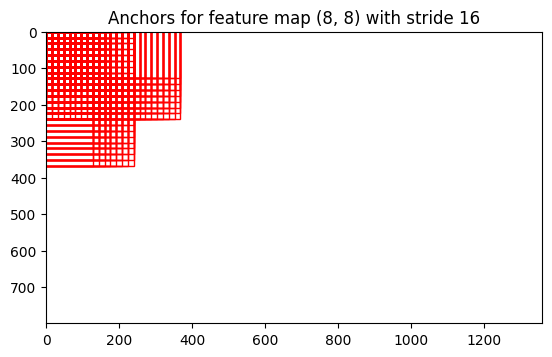

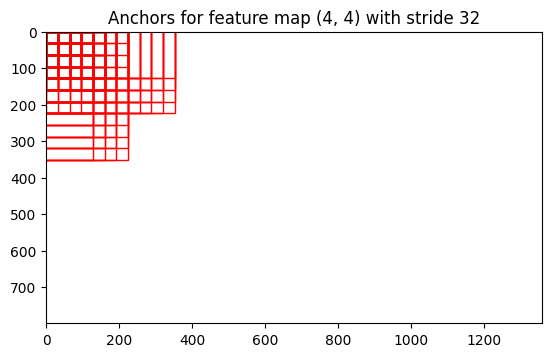

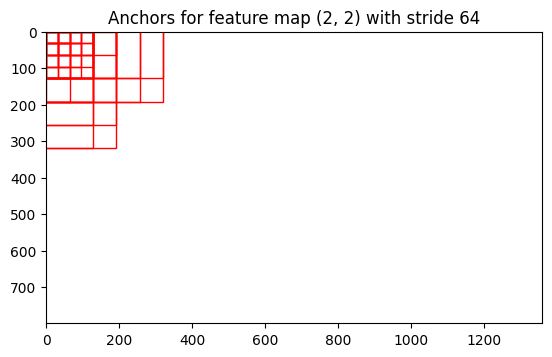

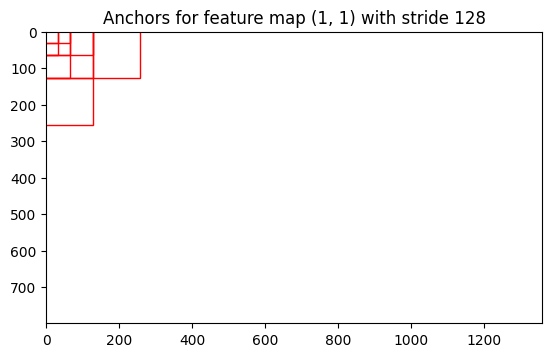

In [ ]:
# Γραφικη απεικονηση των Anchors
image = plt.imread("/content/TrainIJCNN2013/00/00000.ppm")
image = torch.ones((800, 1360, 3))  # Dummy εικόνα (μορφή HxWxC)
scales = [64, 128, 256]  # Κλίμακες των anchors
ratios = [(1, 1), (1, 2), (2, 1)]  # Αναλογίες διαστάσεων
feature_map_sizes = [(8, 8), (4, 4), (2, 2), (1, 1)]  # Διαστάσεις feature maps
strides = [16, 32, 64, 128]  # Stride για κάθε feature map

# Βρόχος για απεικόνιση anchors σε κάθε feature map
for idx, feature_map_size in enumerate(feature_map_sizes):
    stride = strides[idx]
    anchors = generate_anchors(scales, ratios, feature_map_size, stride)
    plot_anchors(image.numpy(), anchors, feature_map_size, stride)


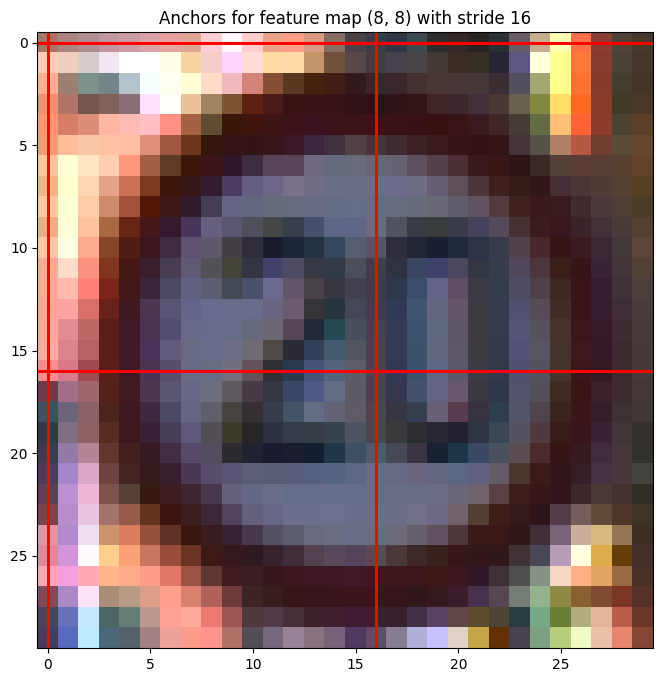

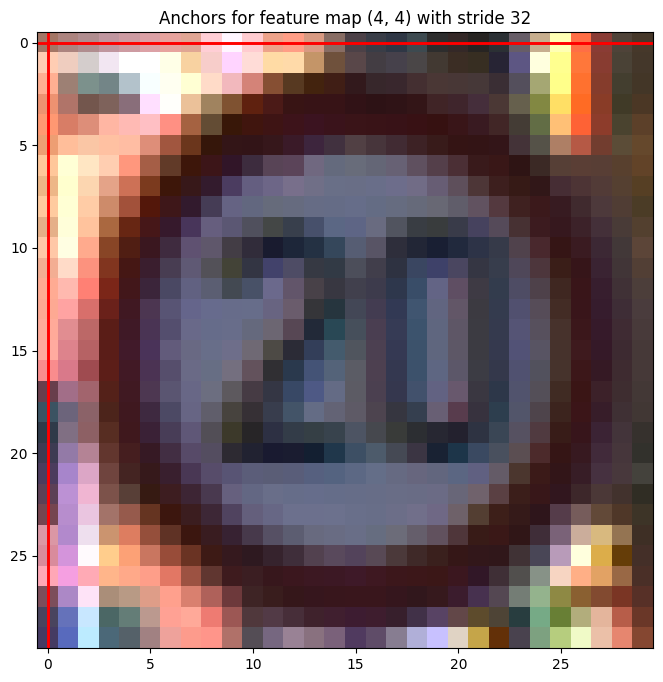

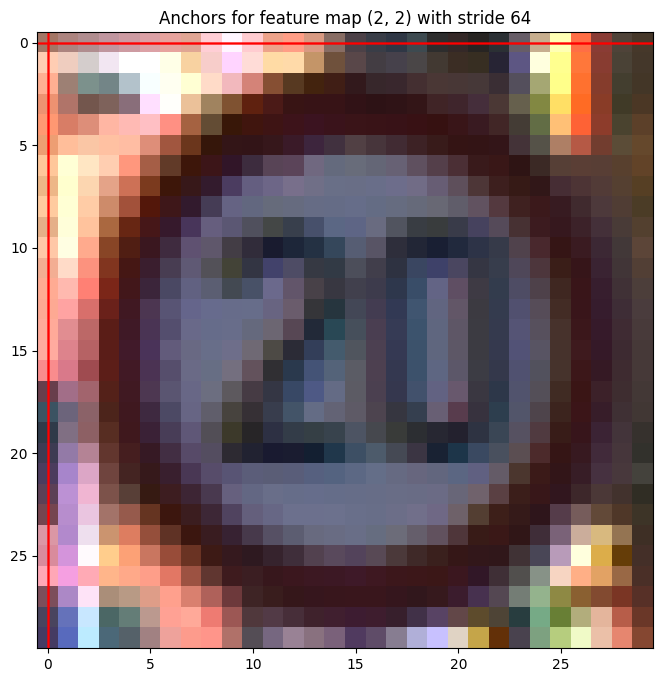

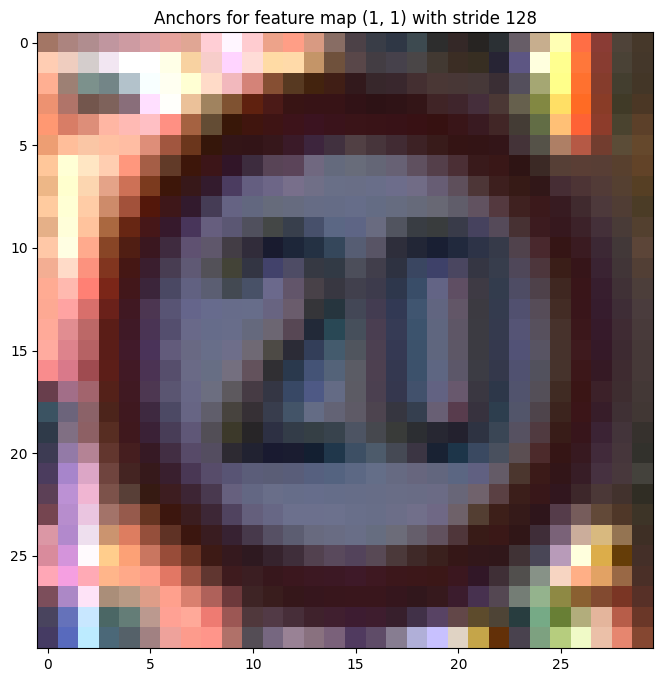

In [ ]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Δημιουργία anchor boxes για ένα συγκεκριμένο feature map
def generate_anchors(scales, ratios, feature_map_size, stride):
    anchors = []
    for i in range(feature_map_size[0]):
        for j in range(feature_map_size[1]):
            center_x = j * stride
            center_y = i * stride
            for scale in scales:
                for ratio in ratios:
                    w = scale * ratio[0]
                    h = scale * ratio[1]
                    anchors.append([center_x, center_y, w, h])
    return torch.tensor(anchors)

# Απεικόνιση anchors σε μία εικόνα
def plot_anchors(image, anchors, feature_map_size, stride):
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    # Μετατροπή συντεταγμένων anchor boxes σε κλίμακα εικόνας
    anchors = anchors.numpy()
    for anchor in anchors:
        center_x, center_y, w, h = anchor
        rect = patches.Rectangle((center_x - w / 2, center_y - h / 2), w, h,
                                 linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.title(f"Anchors for feature map {feature_map_size} with stride {stride}")
    plt.show()

# Φόρτωση της πραγματικής εικόνας
image_path = "/content/TrainIJCNN2013/00/00000.ppm"
image = plt.imread(image_path)

# Anchor configurations
scales = [64, 128, 256]  # Κλίμακες των anchors
ratios = [(1, 1), (1, 2), (2, 1)]  # Αναλογίες διαστάσεων
feature_map_sizes = [(8, 8), (4, 4), (2, 2), (1, 1)]  # Διαστάσεις feature maps
strides = [16, 32, 64, 128]  # Stride για κάθε feature map

# Βρόχος για απεικόνιση anchors σε κάθε feature map
for idx, feature_map_size in enumerate(feature_map_sizes):
    stride = strides[idx]
    anchors = generate_anchors(scales, ratios, feature_map_size, stride)
    plot_anchors(image, anchors, feature_map_size, stride)


# Visualize Predictions

In [ ]:
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as T

# Map class IDs to class names
CLASS_ID_TO_INT = {i: i for i in range(42)}  # 42 κατηγορίες
CLASS_ID_TO_INT[0] = 0  # Το background

def visualize_predictions(image_path, model, threshold=0.1):
    """
    Visualize predictions on a single image.

    Args:
    - image_path: Path to the input image.
    - model: Trained Faster R-CNN model.
    - threshold: Confidence threshold for displaying predictions.
    """
    # Load and preprocess the image
    img = Image.open(image_path).convert("RGB")
    transform = T.Compose([T.ToTensor()])
    img_tensor = transform(img).to(device)

    # Make predictions
    with torch.no_grad():
        prediction = model([img_tensor])

    # Extract boxes, labels, and scores
    pred_boxes = prediction[0]['boxes'].cpu().numpy()
    pred_scores = prediction[0]['scores'].cpu().numpy()
    pred_labels = prediction[0]['labels'].cpu().numpy()

    # Draw boxes on the original image
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
        if score >= threshold:
            x1, y1, x2, y2 = box.astype(int)
            class_name = CLASS_ID_TO_INT[label]

            # Draw rectangle and label
            cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img_cv, f"{class_name}: {score:.2f}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


Visualizing predictions for: 00236.ppm


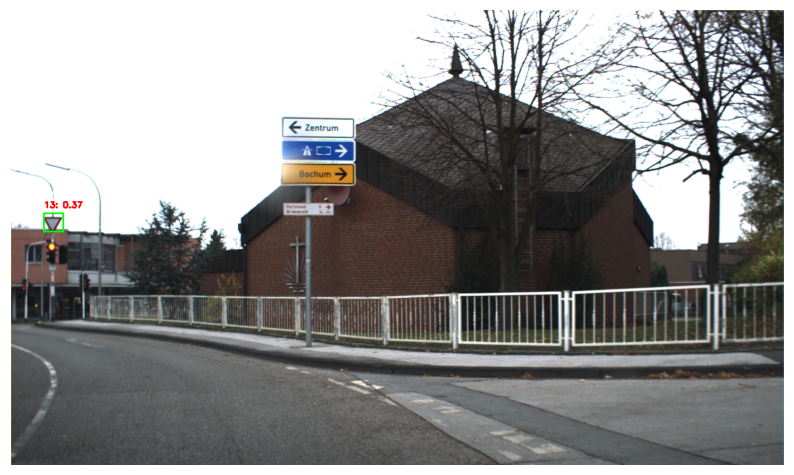

Visualizing predictions for: 00092.ppm


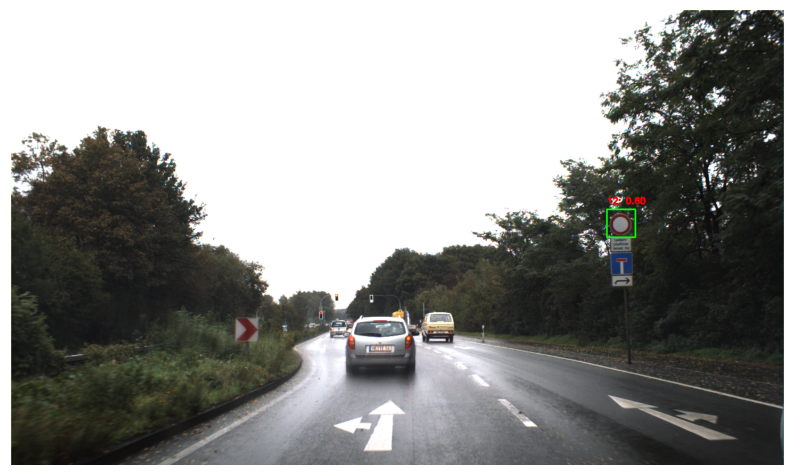

Visualizing predictions for: 00282.ppm


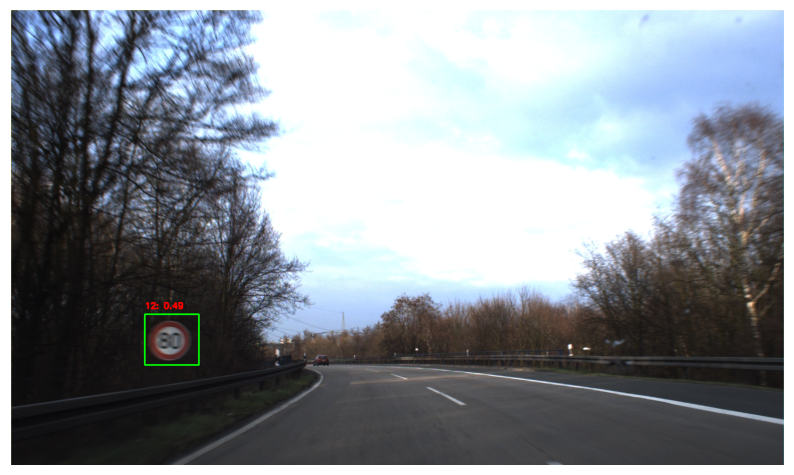

Visualizing predictions for: 00249.ppm


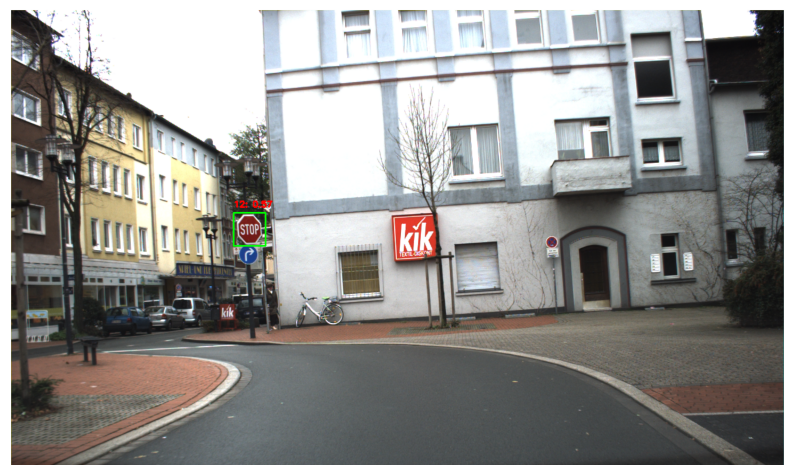

Visualizing predictions for: 00251.ppm


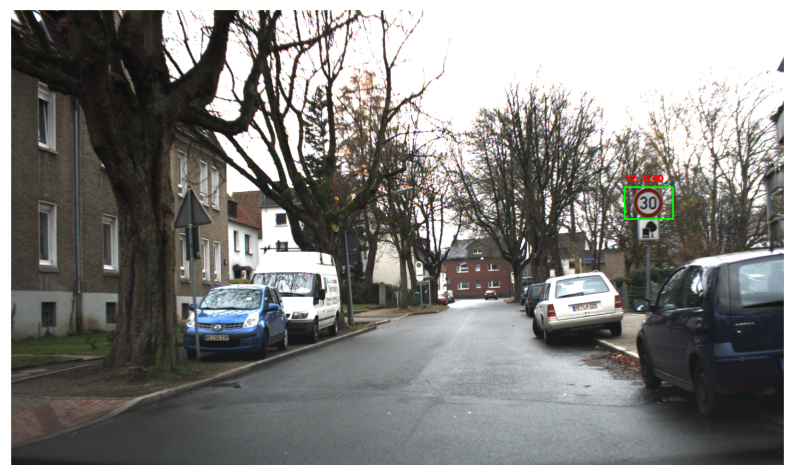

In [ ]:
import os
import numpy as np
# Test images directory
test_images_dir = 'TestIJCNN2013Download'
os.makedirs(test_images_dir, exist_ok=True)

# List all test images
test_images = os.listdir(test_images_dir)

# Visualize predictions for a few images
for i in range(5):  # Visualize first 5 images
    image_path = os.path.join(test_images_dir, test_images[i])
    print(f"Visualizing predictions for: {test_images[i]}")
    visualize_predictions(image_path, model, threshold=0.2)


In [ ]:
def evaluate_map(model, dataloader, device, iou_threshold=0.3, confidence_threshold=0.1):
    """
    Evaluate mean Average Precision (mAP) on the test dataset with a lower confidence threshold.
    """
    model.eval()
    all_true_boxes = []
    all_pred_boxes = []
    all_scores = []
    all_labels = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for i, output in enumerate(outputs):
                pred_boxes = output["boxes"].cpu().numpy()
                pred_scores = output["scores"].cpu().numpy()
                pred_labels = output["labels"].cpu().numpy()

                true_boxes = targets[i]["boxes"].cpu().numpy()
                true_labels = targets[i]["labels"].cpu().numpy()

                # Filter predictions by confidence threshold
                mask = pred_scores >= confidence_threshold
                pred_boxes = pred_boxes[mask]
                pred_scores = pred_scores[mask]
                pred_labels = pred_labels[mask]

                all_pred_boxes.append(pred_boxes)
                all_scores.append(pred_scores)
                all_labels.append(pred_labels)
                all_true_boxes.append(true_boxes)

    # Compute mAP as before
    aps = []
    for class_id in range(1, num_classes):  # Skip background class (class_id=0)
        precisions = []
        recalls = []
        scores = []

        for pred_boxes, pred_scores, pred_labels, true_boxes, true_labels in zip(
            all_pred_boxes, all_scores, all_labels, all_true_boxes, all_true_boxes
        ):
            # Filter predictions and ground truths for the current class
            pred_mask = pred_labels == class_id
            true_mask = true_labels == class_id

            class_pred_boxes = pred_boxes[pred_mask]
            class_pred_scores = pred_scores[pred_mask]
            class_true_boxes = true_boxes[true_mask]

            # Match predictions to ground truths using IoU
            matched_gt = set()
            for pred_box, score in zip(class_pred_boxes, class_pred_scores):
                best_iou = 0
                best_gt_idx = -1
                for gt_idx, true_box in enumerate(class_true_boxes):
                    if gt_idx in matched_gt:
                        continue
                    iou = box_iou(
                        torch.tensor(pred_box).unsqueeze(0),
                        torch.tensor(true_box).unsqueeze(0)
                    ).item()
                    if iou > best_iou and iou >= iou_threshold:
                        best_iou = iou
                        best_gt_idx = gt_idx

                # Update matched ground truths
                if best_iou >= iou_threshold:
                    matched_gt.add(best_gt_idx)
                    precisions.append(1)
                    recalls.append(1)
                else:
                    precisions.append(0)
                    recalls.append(0)
                scores.append(score)

        # Compute AP for this class
        if scores:
            aps.append(average_precision_score(recalls, scores))

    # Calculate mean AP
    mAP = sum(aps) / len(aps) if aps else 0
    return mAP

# Evaluate mAP on the test dataset
mAP = evaluate_map(model, test_loader, device)
print(f"Test mAP: {mAP:.4f}")


NameError: name 'average_precision_score' is not defined